# Explore here

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

In [2]:
df = pd.read_csv('/workspaces/temporary_series-RDH/data/raw/temporary_series_sales.csv', parse_dates = ['date'])
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [3]:
#revisión tipo de variables presentes en el dataSet
df.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [4]:
#Dimensiones de nuestro DataSet
df.shape

(366, 2)

In [5]:
#Revisión de datos faltantes:
df.isna().mean()*100

date     0.0
sales    0.0
dtype: float64

In [6]:
#Revisión de datos duplicados:
df.duplicated().sum()

np.int64(0)

In [7]:
#Revisión de valores únicos por columnas (valor único por dia):
df.nunique()

date     366
sales    366
dtype: int64

In [8]:
#Creamos nueva columna con valores de fechas sin horas, minutos y segundos:
df['date_days'] = df['date'].dt.date
df.head()

,date,sales,date_days
0,2022-09-03 17:10:08.079328,55.292157,2022-09-03
1,2022-09-04 17:10:08.079328,53.803211,2022-09-04
2,2022-09-05 17:10:08.079328,58.141693,2022-09-05
3,2022-09-06 17:10:08.079328,64.530899,2022-09-06
4,2022-09-07 17:10:08.079328,66.013633,2022-09-07


In [9]:
#Día de inicio del registro:
df['date_days'].min()

datetime.date(2022, 9, 3)

In [10]:
#Día final de la medición:
df['date_days'].max()

datetime.date(2023, 9, 3)

In [11]:
#Números de registros de fechas que coincidan con número de registros iniciales:
(df['date_days'].max() - df['date_days'].min()).days

365

In [12]:
#Creamos un nuevo df sin la columna de fechas con horas y minutos:
df_days = df.drop(columns = ['date'])
df_days.to_csv('/workspaces/temporary_series-RDH/data/interim/df_days.csv')

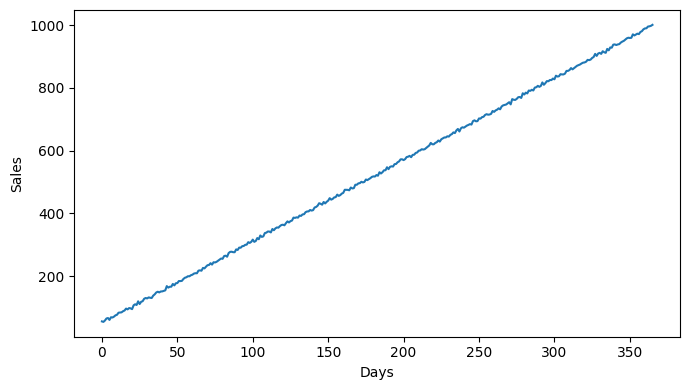

In [13]:
#Visualización de ventas por unidad de tiempo (dias):

fig, axis = plt.subplots(figsize = (7, 4))

sns.lineplot(x=df_days.index, y=df_days['sales'])
plt.tight_layout()
plt.xlabel('Days')
plt.ylabel('Sales')
plt.show()

In [14]:
#Ordenamos del df por fecha (antiguo a reciente):
df_days = df_days.sort_values('date_days')
df_days

,sales,date_days
0,55.292157,2022-09-03
1,53.803211,2022-09-04
2,58.141693,2022-09-05
3,64.530899,2022-09-06
4,66.013633,2022-09-07
...,...,...
361,989.600354,2023-08-30
362,994.987326,2023-08-31
363,995.814415,2023-09-01
364,997.350214,2023-09-02


### Análisis de la serie temporal (descomposición)

In [15]:
#Necesito convertir 'date_days' en un formato datetime

df_days['date_days'] = pd.to_datetime(df_days['date_days'])  # convertimos datetime.date a datetime64[ns]
df_days = df_days.set_index('date_days') #Indexamos fechas

In [16]:
df.index.freq = 'D'  #El índice tiene frecuencia diaria
print(f"La frecuencia de la serie temporal es: {df.index.freq}")

La frecuencia de la serie temporal es: D


### **Comentario**
El tensor mínimo para la cual existen datos, de acuerdo a lo visto, es de un día (24h). Es por eso que hemos eliminado las horas, minutos y segundos del registro. 

### Método de Descomposición : tendencia, temporalidad y residuos

In [17]:
#Definición del método de descomposición
decomposition = seasonal_decompose(df_days['sales'], period =30) #Período de 30 dias (mensual)
decomposition

## **Comentario**
He puesto un período mensual puesto que nuestros datos tienen el registro diario de un año exacto, pero entiendo que podríamos haber puesto una periodicidad semanal (7d) o anual (365d). 

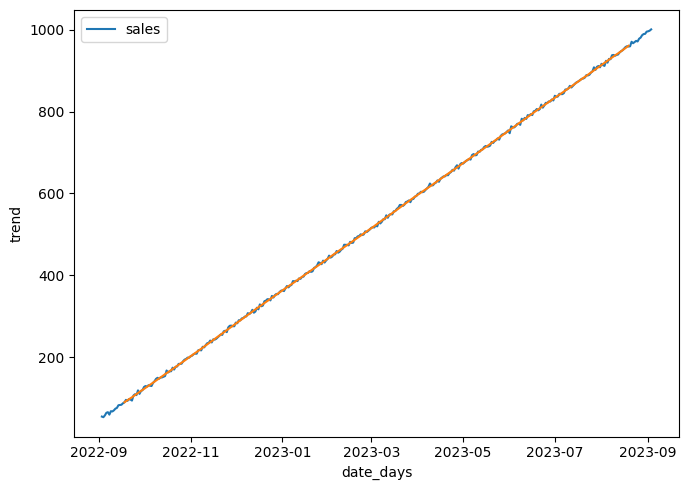

In [18]:
## Análisis de tendencia 
trend = decomposition.trend
fig, axis = plt.subplots(figsize = (7,5))

sns.lineplot(data = df_days)
sns.lineplot(data = trend)

plt.tight_layout()
plt.show()

## **Comentario**
No se ve con precisión el movimiento de la curva de tendencia sobre los datos en el tiempo, pero lo que si se aprecia es una tendencia positiva a lo largo del año y además es bastante plana. Las ventas aumentan con el tiempo de forma casi lineal.

Sin embargo, hacer los 3 gráficos por valor calculado de descomposición, no me permitirá ver ninguna variación dada la escala en la que se encuentra. Utlizaré el plt para decomposition al final para reflejarlo mejor. 

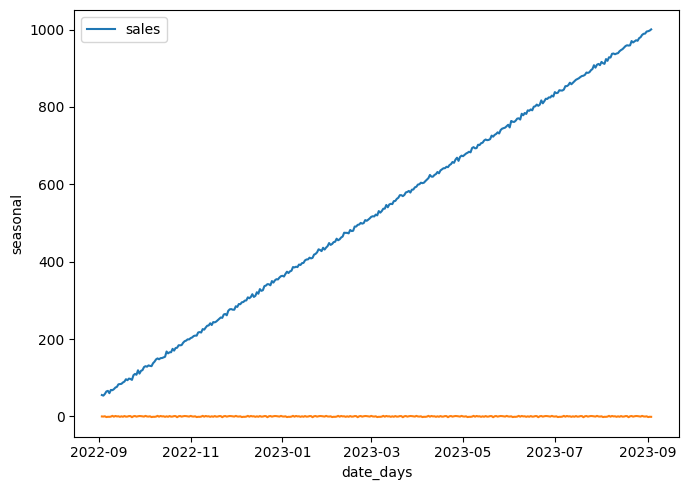

In [19]:
## Descomposición por temporada

seasonal = decomposition.seasonal
fig, axis = plt.subplots(figsize = (7, 5))

sns.lineplot(data = df_days)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

In [20]:
## Prueba de Dickey-Fuller para evaluar estadísticamente si nuestros datos constan de estacionaridad:

result = adfuller(df_days['sales'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("La serie es estacionaria")
else:
    print("La serie NO es estacionaria")

ADF Statistic: 0.545414193706378
p-value: 0.9861899815311064
La serie NO es estacionaria


## **Comentario**

En principio, teniendo una tendencia y una fluctuación de sus parámetros en el tiempo (con una tendencia creciente), por lo general, no debería ser estacionaria. Pero confirmamos con el estadístico de Dickey-Fuller para salir de dudas. 

El supuesto del estadístico (hipótesis nula), es que la serie sea estacionaria (sus estadísticos no cambian con el tiempo: media y varianza constante). Dado que el p-value es mucho mayor a 0,05, rechazamos la hipótesis nula, admitiendo que la serie no es estacionaria, algo que podíamos ver en el gráfico de ventas en el tiempo. 

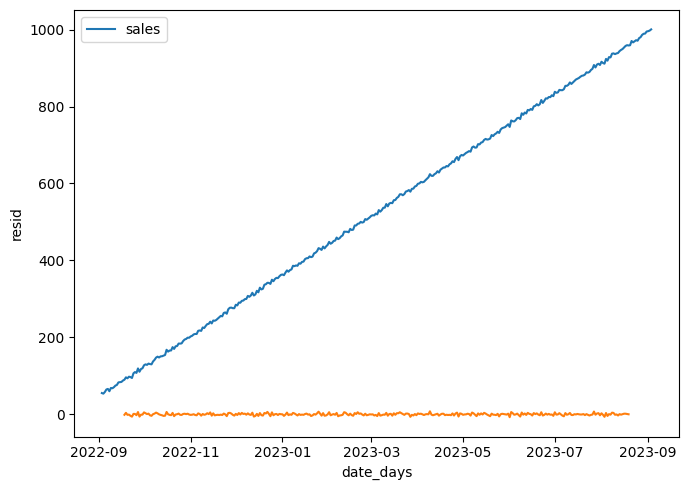

In [21]:
## Análisis de residuales (errores)

residual = decomposition.resid
fig, axis = plt.subplots(figsize = (7, 5))
sns.lineplot(data = df_days)
sns.lineplot(data = residual)
plt.tight_layout()
plt.show()

## **Comentario**
Con estos gráficos no puedo determinar si existe variabilidad y tampoco se puede ver cómo fluctúan los residuales en ellos. Haré un plot donde pueda mirar con más detalle y poder hacer alguna interpretación más acertada.

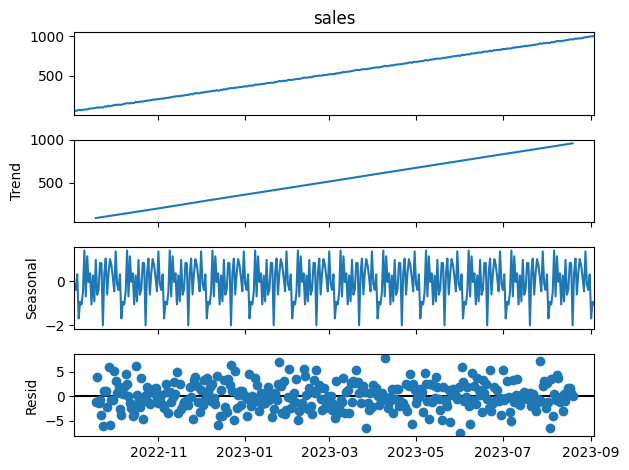

In [22]:
#Visualización de los tres valores de descomposición: Trend, Seasonal y Resid.
decomposition.plot()
plt.show()

In [23]:
##Prueba de Dickey-Fuller para evaluar de la estacionareidad del ruido (residuos) de la descomposición.

result = adfuller(residual.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < 0.05:
    print("Los residuales son estacionarios")
else:
    print("Los residuales NO son estacionarios")

ADF Statistic: -10.482643018173057
p-value: 1.2025891385804124e-18
Los residuales son estacionarios


### **Comentario de revisión**

De acuerdo al estadístico, asumiendo la hipótesis nula como que la serie es estacionaria, teniedo un p-value muy pequeño (menor a 0.05), no podemos rechazar la hipótesis nula, por ende, los residuales si son estacionarios. 

Si los residuales son estacionarios (conocidos como ruido blanco), quiere decir que:

La parte que queda después de quitar tendencia y estacionalidad no tiene patrones sistemáticos ni cambios en su media o varianza a lo largo del tiempo. Quiere decir que la variabilidad es constante y aleatoria.

Por otra parte, se puede ver una 'periodicidad' o patrón de variación de ventas cada determinado tiempo (estacionalidad), además, parece ser cíclico. Para poder determinarlo, utilizaremos ACF y mediremos la descomposición en 'season' con un lags de 30 dias. 

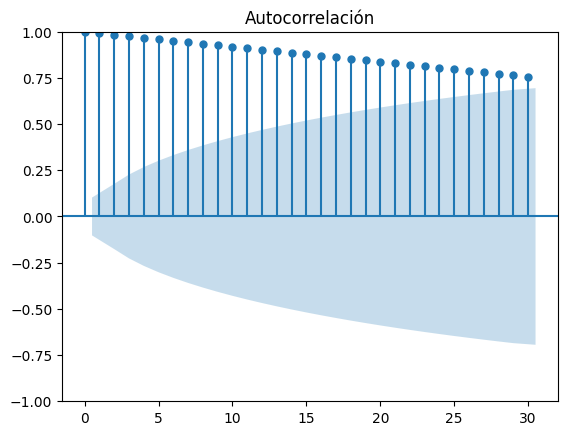

In [24]:
#Evaluación de estacionalidad en 30 dias (mensual). Para sugerir 'q' en el modelo.
plot_acf(df_days['sales'], lags=30)
plt.title('Autocorrelación')
plt.show()

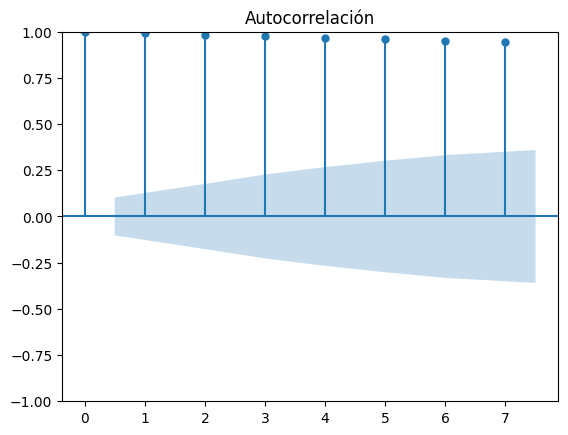

In [25]:
#Evaluación de estacionalidad semanal (7 dias)
plot_acf(df_days['sales'], lags=7)
plt.title('Autocorrelación')
plt.show()

## **Comentario**

Al graficar la función de autocorrelación (ACF), observamos picos equidistantes que indican una estacionalidad clara en la serie. La altura de los picos decrece levemente con el aumento del lag, lo que sugiere un patrón estacional. Estos picos aparecen cada 30 días (lags), lo que corresponde a un patrón de tipo mensual.

<Axes: title={'center': 'Estacionalidad mensual'}, xlabel='date_days'>

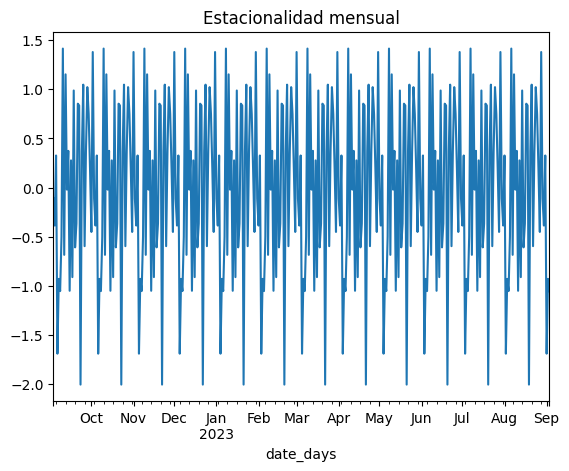

In [26]:
#Revisión de la duración de la estacionalidad
decomposition_30 = seasonal_decompose(df_days['sales'], period=30)
decomposition_30.seasonal.plot(title='Estacionalidad mensual')

In [27]:
# Consideración de diferenciación (serie NO estacionaria):
df_days['sales_diff'] = df_days['sales'].diff()
df_days.dropna(inplace=True)

### **Partición de Datos**

In [28]:
#Medición para los próximos 30 dias (mensual):
df_train = df_days.iloc[:-30] #todos menos los 30 últimos dias
df_test = df_days.iloc[-30:]

## Revisión interna: 

Pude utilizar el siguiente código para hacerlo más sostenible, sin embargo, haré pruebas dado que el dataSet no es tan amplio. 

split = int(len(df_days) * 0.8) (Asignar el 80% de los datos totales)

df_train = df_days.iloc[:split]

df_test = df_days.iloc[split:]

No tendría claro en qué casos usarlos mejor. Entendería que en dataSets mucho más complejos, convendría utilizar porcentajes para hacerlo más orgánico y replicable. 

In [29]:
#Modelado con ARIMA: A pesar de haber hecho el cálculo diff, dejaremos que el modelo lo ejecute dentro de sus parámetros.

model = ARIMA(df_train['sales'], order=(1,1,1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [30]:
#Métricas del modelo ARIMA
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  335
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -964.882
Date:                Tue, 24 Jun 2025   AIC                           1935.765
Time:                        19:10:01   BIC                           1947.198
Sample:                    09-04-2022   HQIC                          1940.324
                         - 08-04-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.001    702.504      0.000       0.997       1.003
ma.L1         -0.9995      0.938     -1.066      0.287      -2.838       0.839
sigma2        18.6534     17.730      1.052      0.2

### **Observaciones**
EL coeficiente ar.1, con su valor 1, nos indica una alta dependiencia temporal (el valor actual tiene una muy alta correlación con el valor anterior), con un p asociado menos a 0.05, quiere decir que es estadísticamente signficativo. 

El coeficiente maL1 (media móvil) sin embargo, logra medir variaciones (errores) de fechas anteriores sobre las actuales, puesto que el valor es cercano a -1, dicha variación podría tener un impacto sobre las mediciones actuales. Dado que el p > 0.05, no es estadísticamente significativo, asi que el efecto podría no ser certero. 

In [31]:
#Obtención de métricas para evaluación de la predicción (con la variable original)
mse = mean_squared_error(df_test['sales'], forecast)
mae = mean_absolute_error(df_test['sales'], forecast)
print(f"MSE: {mse}, MAE: {mae}")

MSE: 10.374430536200267, MAE: 2.6356565759330883


In [32]:
# Raiz cuadrada de MSE (media del error)
rmse = np.sqrt(10.37)
print(rmse)

3.2202484376209237


## **Comentarios**
El MSE (error medio cuadrático) si obtenemos la raíz (RMSE) podríamos decir que los valores de la predicción se desvían en promedio unas 3.22 unidades de los valores de venta reales (error promedio respecto al valor real). 

Por otra parte el MAE (Error medio absoluto), se acerca bastante a la rmse, pero a diferencia de éste, mide el error absoluto entre la predicción y el valor real. Esta medida de unidad sigue siendo baja comparada con la escala de valores de nuestros datos de ventas. La predicción se desvía en promedio unas 2,64 unidades de los valores reales de venta.

En resumen, el modelo predice bastante bien el comportamiento de nuestros datos y por ende, los valores que resultan de la predicción cumplirán el mismo y se acercará a la realidad en ventas de los próximos 30 dias. 

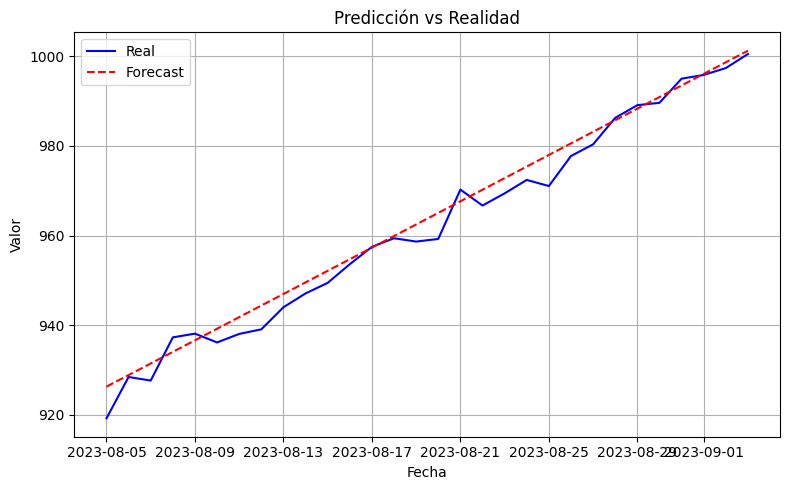

In [33]:
#Visualización de la predicción vs nuestros datos reales.
forecast = pd.Series(forecast, index=df_test.index)

plt.figure(figsize=(8, 5))
plt.plot(df_test['sales'], label='Real', color='blue')
plt.plot(forecast, label='Forecast', color='red', linestyle='--')
plt.title('Predicción vs Realidad')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

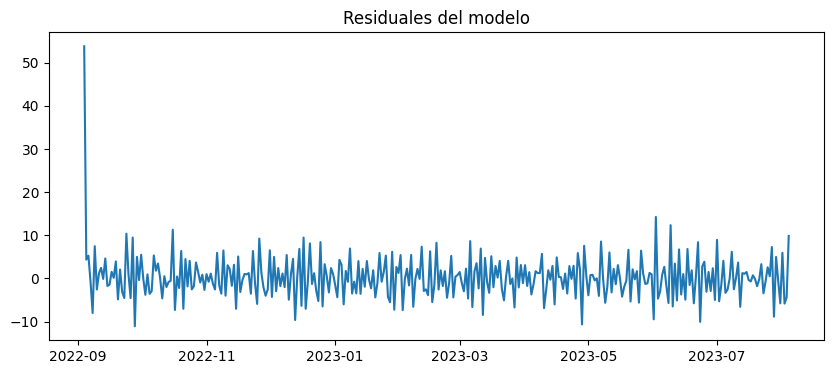

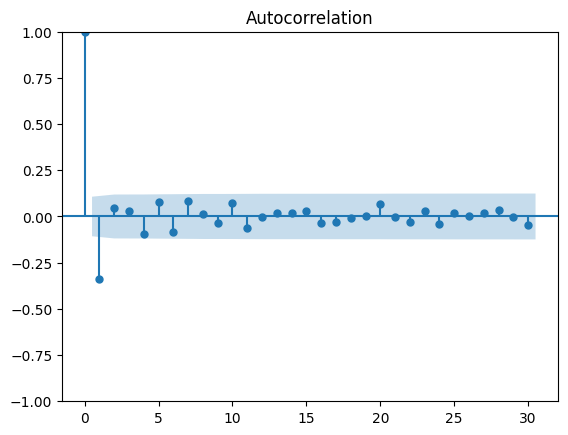

In [34]:
#Evaluación de residuales después del modelo 
residuals_model = model_fit.resid
plt.figure(figsize=(10,4))
plt.plot(residuals_model)
plt.title('Residuales del modelo')
plt.show()

#ACF de los residuos para comprobar ruido blanco
plot_acf(residuals_model, lags=30)
plt.show()

In [35]:
#Prueba de Dickey-Fuller para evaluar de la estacionareidad del ruido (residuos) sobre el modelo:
result_model = adfuller(residuals_model.dropna())
print(f'ADF Statistic: {result_model[0]}')
print(f'p-value: {result_model[1]}')
if result[1] < 0.05:
    print("Los residuales son estacionarios")
else:
    print("Los residuales NO son estacionarios")

ADF Statistic: -12.947378409695713
p-value: 3.433046500235481e-24
Los residuales son estacionarios


## **Comentario**

Si los residuos después del entrenamiento son estacionarios (tal como el estadístico muestra), entonces, el modelo ha capturado toda la estructura temporal de los datos reales y por ende, los errores no están correlacionados y no tienen ningún patrón temporal. Quiere decir, que se ha capturado la máxima variabilidad temporal de nuestra variable objetivo y el modelo se ha ajustado correctamente. 

### **Prueba con SARIMA sabiendo que existe estacionalidad**

In [36]:
# Al detectar estacionalidad, probamos con el modelo SARIMA (asumiendo estacionalidad mensual)
model_sarima = SARIMAX(df_train['sales'], order=(1,1,1), seasonal_order=(1,1,1,30))
model_sarima_fit = model_sarima.fit()

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [37]:
#Forecast - modelo de predicción para cada 30. 
steps = 30
forecast_result = model_sarima_fit.get_forecast(steps=steps)
forecast_sarima = forecast_result.predicted_mean
conf_int = forecast_result.conf_int() #Con intervalo de confianza

In [38]:
#Métricas de error para SARIMA
mse = mean_squared_error(df_test['sales'], forecast_sarima)
mae = mean_absolute_error(df_test['sales'], forecast_sarima)
print(f'SARIMA MSE: {mse:.3f}, MAE: {mae:.3f}')

SARIMA MSE: 6.903, MAE: 2.035


## **Comentario**
Los errores disminuyen considerablemente, lo cual ajusta mucho más este modelo a los datos de entrenamiento. 

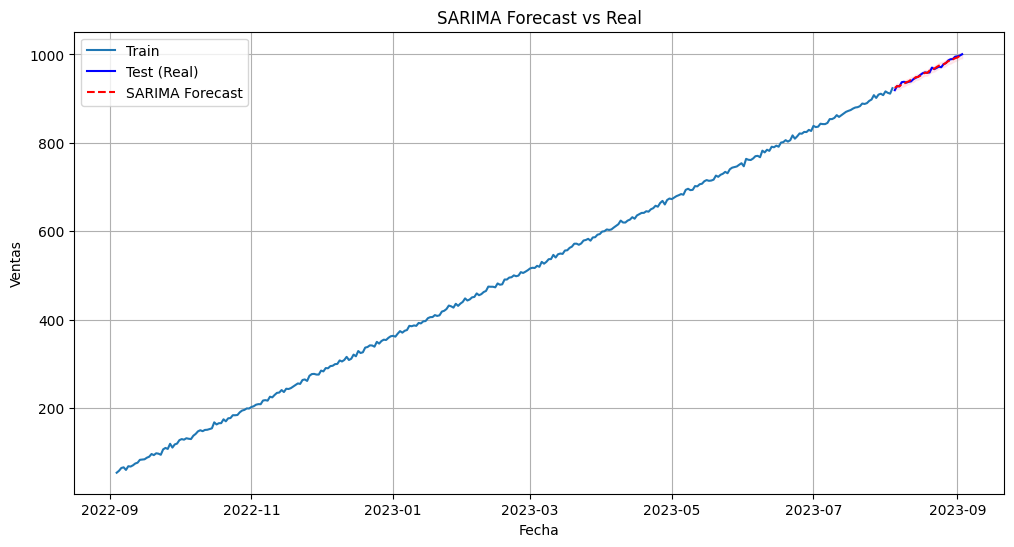

In [39]:
# Gráfico de predicción vs real con bandas de confianza
plt.figure(figsize=(12,6))
plt.plot(df_train.index, df_train['sales'], label='Train')
plt.plot(df_test.index, df_test['sales'], label='Test (Real)', color='blue')
plt.plot(df_test.index, forecast_sarima, label='SARIMA Forecast', color='red', linestyle='--')
plt.fill_between(df_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast vs Real')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
#Guardado del modelo
joblib.dump(model_fit, '/workspaces/temporary_series-RDH/models/arima_model.pkl')

['/workspaces/temporary_series-RDH/models/arima_model.pkl']